# 1. Implement your own EM algorithm to cluster the old faithful data set into 4 groups. We encourage you not  to use Scikit learn's implementation of EM algorithm.  If you are facing too much difficulty during implementation you can use packages no marks will be deducted for that. However, please try your best to avoid using packages.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
from scipy.stats import multivariate_normal

In [2]:
df = pd.read_csv('oldFaithful.csv')
df

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85
...,...,...
267,4.117,81
268,2.150,46
269,4.417,90
270,1.817,46


In [3]:
X = df.values

# Guasian Mixture Model Using EM 
Code has been taken from: "http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/"

## Initialization!
### Setting Probability of each class such that sum should be 1
### Setting Mean and SD of each gaussian to random values

In [4]:
def init(X, k):
    n, m = X.shape
    
    #prob is probability matrix filled with prob 1/k for each class.
    prob = np.full(shape = k, fill_value = 1/k)
    
    #Weights matrix with same shape as input
    weights = np.full(shape = X.shape, fill_value = 1/k)
    
    #random numbers between 0, n of size k
    ran = np.random.randint(0, n, k)
    
    #All random means and sd
    mu = [X[r,:] for r in ran]
    si = [np.cov(X.T) for _ in range(k)]
    #Gives back covariance matrix
    
    return prob, weights, mu, si

## Expectation and Log-likelihood

The following formulas are being implemented:


# $ lnP(X|\pi, \mu, \Sigma) = \sum_{i = 1}^{i = m} ln \sum_{k = 1}^{k = K} \pi_k N(X^i | \mu_k, \Sigma_k) $



# $ \gamma (z^i_k) = \frac{\pi_k N(X^i | \mu_k, \Sigma_k)}{\sum_{j = 1}^{j = k} \pi_j N(X^i | \mu_j, \Sigma_j)}$


In [5]:
#This function is predicting the weights for our present gaussian classes' mus and sigmas.
def predict_prob(X, k, mu, si, prob):
    
    n, m = X.shape
    #size n, k, likelihood matrix
    like = np.zeros((n,k))
    
    for i in range(k):
        
        #Getting the normal distribution for each gaussian class, given the mu and sigma. 
        dist = multivariate_normal(mean = mu[i], cov = si[i])
        
        #Likelihood for that class is the probability density function of the distribution over the data.
        like[:,i] = dist.pdf(X)
        
    #Numerator = likelihood * prob of each class.   
    num = like * prob
    #Denominator is sum of the numerator along all classes. newaxis shifts the axis of the matrix.
    den = num.sum(axis=1)[:, np.newaxis]
    
    #Predicted weights is numerator/denominator.
    weights = num / den
    
    return weights

In [6]:
def expect(X, k, mu, si, prob):
    
    #Get the predicted weights of gaussian class.
    weights = predict_prob(X, k, mu, si, prob)
    
    #updating the probabilities of each class.
    prob = weights.mean(axis = 0)
    
    return weights, prob

## Maximization

The following formula is being implemented:

# $ \mu_k^{new} = \frac{1}{N_k} \sum_{i = 1}^{i = m} \gamma(z^i_k) X^i $

# $ \Sigma_k^{new} = \frac{1}{N_k} \sum_{i = 1}^{i = m} \gamma(z^i_k) (X^i - \mu_k) (X^i - \mu_k)^T $

# $\pi_k^{new} = \frac{N_k}{m} $

In [7]:
def maxi(X, k, weights, mu, si):
    
    for i in range(k):
        w = weights[:,[i]]
        tot_w = w.sum()
        
        #Updating the mus and sigmas.
        mu[i] = ((X * w).sum(axis = 0)) / tot_w
        si[i] = np.cov(X.T, aweights = (w/tot_w).flatten(), bias = True)
    
    return mu, si

## Running GMM and Predicting values

In [8]:
def train(X, k, epochs):
    #Initialization
    prob, weights, mu, si = init(X, k)
    
    #Running Expectation-Maximization for given number of times.
    for i in range(epochs):
        weights, prob = expect(X, k, mu, si, prob)
        
        mu, si = maxi(X, k, weights, mu, si) 
        
    return mu, si, prob, weights

In [9]:
def predict(X, k, mu, si, prob):
    
    #Using weights to predict lables, once the EM stops running.
    w = predict_prob(X, k, mu, si, prob)
    
    return np.argmax(w, axis = 1)

In [10]:
def gausian(X, k, epochs):
    
    #Running EM
    mu, si, prob, weights = train(X, k, epochs)
    
    #Predicting labels
    pred_lab = predict(X, k, mu, si, prob)
    
    return pred_lab, mu, si, prob

## Defining Final EM and plotting function
Code taken from study notes

In [11]:
def EM1(X, k, epochs = 100):
    
    #Results from gmm.
    pred_lab, mu, si, prob = gausian(X, k, epochs)
    
    print("prior: ", prob)
    
    print("----------------------------------------------------------------------------------------")
    
    print("mean: ", mu)
    
    print("----------------------------------------------------------------------------------------")
    
    print("Covariance: ", si)
    
    print("----------------------------------------------------------------------------------------")
    
    fig, (ax1) = plt.subplots(1, 1)

    fig.set_size_inches(20, 15)
    
    cmap = cm.get_cmap("Spectral")
    colors = cmap(pred_lab.astype(float) / k)

    ax1.scatter(df.iloc[:, 0], df.iloc[:, 1], marker='o', s=60, lw=1, alpha=0.5, c=colors)

    plt.show()

## Plotting EM for 4 classes

prior:  [0.34085227 0.4016084  0.08981191 0.16772742]
----------------------------------------------------------------------------------------
mean:  [array([ 2.00480917, 54.39269551]), array([ 4.40765728, 80.5006914 ]), array([ 3.56365949, 74.10565152]), array([ 4.25826657, 79.72376245])]
----------------------------------------------------------------------------------------
Covariance:  [array([[ 0.04717689,  0.36837079],
       [ 0.36837079, 34.0897635 ]]), array([[ 0.10007615,  1.0365366 ],
       [ 1.0365366 , 37.62855824]]), array([[  0.24594475,   5.13274268],
       [  5.13274268, 129.64631513]]), array([[ 0.17919611, -0.77125741],
       [-0.77125741, 11.26692653]])]
----------------------------------------------------------------------------------------


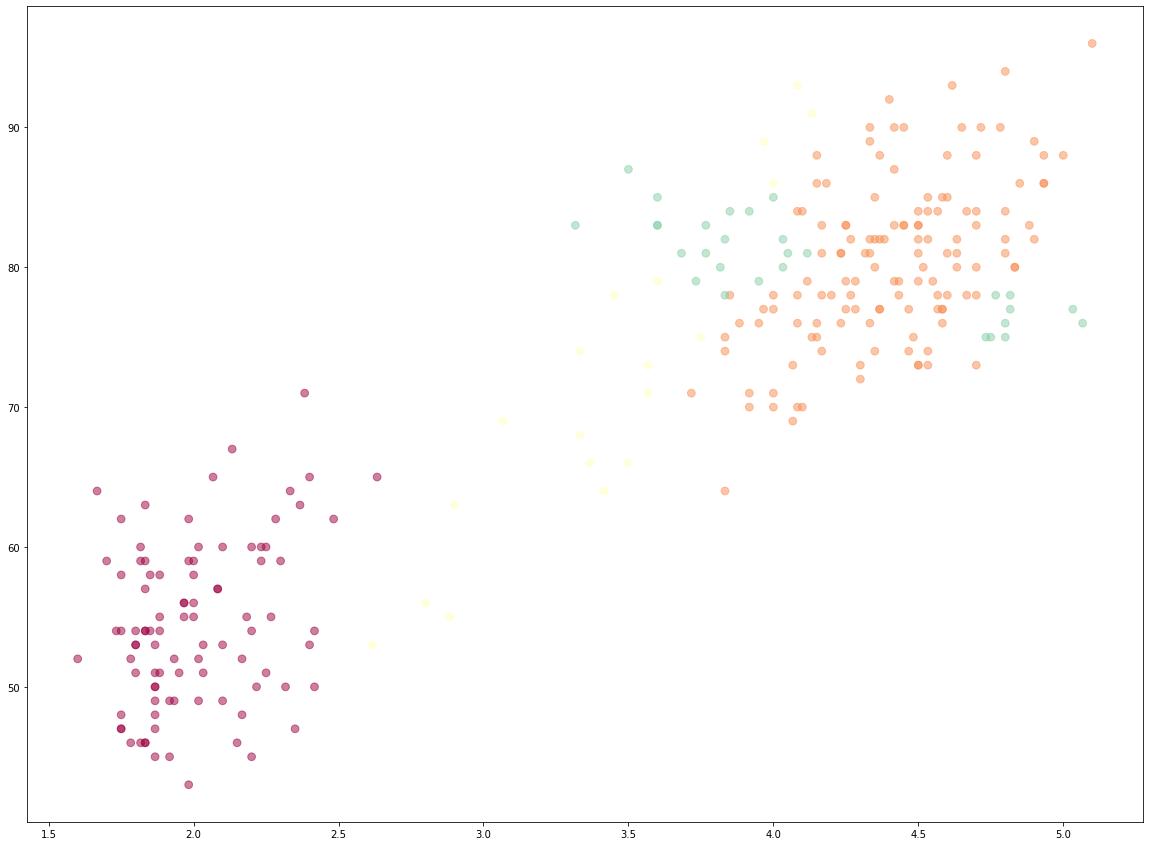

In [12]:
EM1(X, 4)

## EM Using sklearn
Taken from study notes

In [13]:
from sklearn import mixture

def EM2(data, K):

    values = data

    gmm = mixture.GaussianMixture(n_components=K)

    gmm.fit(values)

    predictedLabel = gmm.predict(values) #predict the label

    print("prior :",gmm.weights_)
    
    print("----------------------------------------------------------------------------------------")

    print("mean :",gmm.means_)
    
    print("----------------------------------------------------------------------------------------")

    print("variance :",gmm.covariances_)
    
    print("----------------------------------------------------------------------------------------")

    print("is Converged :",gmm.converged_)
    
    print("----------------------------------------------------------------------------------------")

    fig, (ax1) = plt.subplots(1, 1)

    fig.set_size_inches(20, 15)

    cmap = cm.get_cmap("Spectral")
    colors = cmap(predictedLabel.astype(float) / K)

    ax1.scatter(data.iloc[:, 0], data.iloc[:, 1], marker='o', s=60, lw=1, alpha=0.5, c=colors)

    plt.show()

prior : [0.31594993 0.09047535 0.30842292 0.28515179]
----------------------------------------------------------------------------------------
mean : [[ 4.26527199 83.64912798]
 [ 2.55795639 61.71306761]
 [ 4.37318528 77.03925995]
 [ 1.96368429 53.03819788]]
----------------------------------------------------------------------------------------
variance : [[[ 0.1653814   0.82024957]
  [ 0.82024957 23.35586099]]

 [[ 0.28224435  1.08049151]
  [ 1.08049151 29.78114965]]

 [[ 0.12085008  0.69727378]
  [ 0.69727378 17.32193777]]

 [[ 0.03335274  0.03704334]
  [ 0.03704334 25.02645751]]]
----------------------------------------------------------------------------------------
is Converged : True
----------------------------------------------------------------------------------------


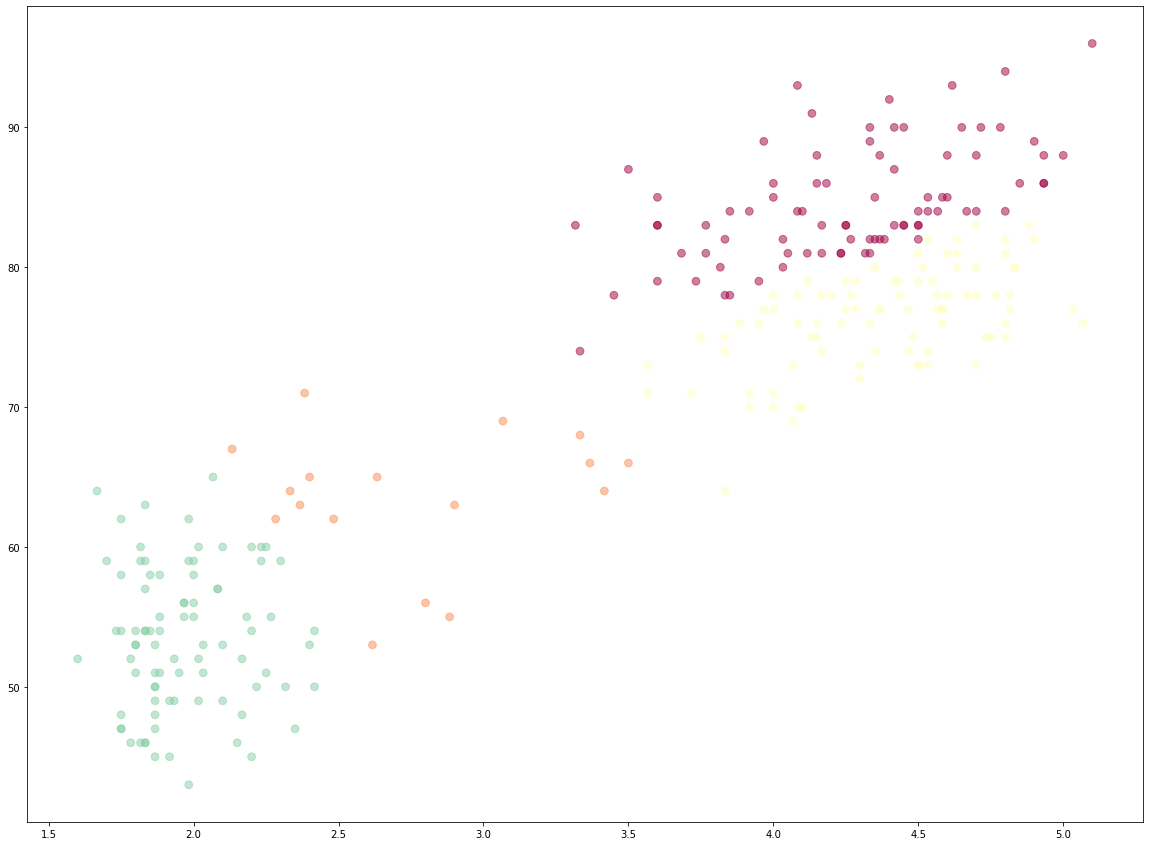

In [14]:
EM2(df, 4)

# 2. In the study notes, you have learned how to implement your own PCA algorithm to reduce the dimensionality of a dataset. In this exercise, you are supposed to perform dimensionality reduction on the iris data set(from 4 to 2) using the Scikit learn's implementation of PCA . The Documentation of which can be found at the link: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# After reducing the dimensionality draw a scatter plot.

In [15]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import datasets

In [16]:
iris = datasets.load_iris()
X= iris.data[:, :4]

In [17]:
pca = PCA(n_components = 2)
pca.fit(X)

PCA(n_components=2)

In [18]:
print("Shape of data: ", X.shape)
print("Shape of pca components: ", pca.components_.shape)
print("PCA Components: ", pca.components_)

Shape of data:  (150, 4)
Shape of pca components:  (2, 4)
PCA Components:  [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]


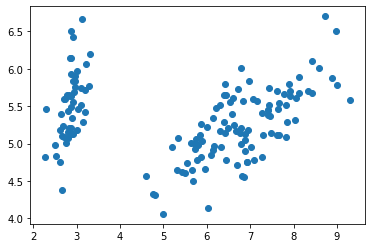

In [19]:
Y = X @ pca.components_.T

plt.scatter(Y[:, 0], Y[:, 1])